# 概述

上一节我们尝试通过更复杂的模型（经典的全连接神经网络和卷积神经网络），提升手写数字识别模型训练的准确性。本节我们继续将“横纵式”教学法从横向展开，如 **图1** 所示，探讨损失函数的优化对模型训练效果的影响。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/8ed4007a16f24549affef4549ba4e2228729b94bc69c479f91c57d0cf3a8bf52" width="1000" hegiht="" ></center>
<center><br>图1：“横纵式”教学法 — 损失函数优化 </br></center>
<br></br>

损失函数是模型优化的目标，用于在众多的参数取值中，识别最理想的取值。损失函数的计算在训练过程的代码中，每一轮模型训练的过程都相同，分如下三步：
1. 先根据输入数据正向计算预测输出。
1. 再根据预测值和真实值计算损失。
1. 最后根据损失反向传播梯度并更新参数。

# 分类任务的损失函数

在之前的方案中，我们复用了房价预测模型的损失函数-均方误差。从预测效果来看，虽然损失不断下降，模型的预测值逐渐逼近真实值，但模型的最终效果不够理想。究其根本，不同的深度学习任务需要有各自适宜的损失函数。我们以房价预测和手写数字识别两个任务为例，详细剖析其中的缘由如下：

1. 房价预测是回归任务，而手写数字识别是分类任务，使用均方误差作为分类任务的损失函数存在逻辑和效果上的缺欠。
1. 房价可以是大于0的任何浮点数，而手写数字识别的输出只可能是0~9之间的10个整数，相当于一种标签。
1. 在房价预测的案例中，由于房价本身是一个连续的实数值，因此以模型输出的数值和真实房价差距作为损失函数（Loss）是符合道理的。但对于分类问题，真实结果是分类标签，而模型输出是实数值，导致以两者相减作为损失不具备物理含义。

那么，什么是分类任务的合理输出呢？分类任务本质上是“某种特征组合下的分类概率”，下面以一个简单案例说明，如 **图2** 所示。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/c9f479c2960140839b259ca7ab2256a0dcd7a714e76a4edfb5377f1566796460" width="700" hegiht="" ></center>
<center><br>图2：观测数据和背后规律之间的关系 </br></center>
<br></br>


在本案例中，医生根据肿瘤大小$x$作为肿瘤性质$y$的参考判断（判断的因素有很多，肿瘤大小只是其中之一），那么我们观测到该模型判断的结果是$x$和$y$的标签（1为恶性，0为良性）。而这个数据背后的规律是不同大小的肿瘤，属于恶性肿瘤的概率。观测数据是真实规律抽样下的结果，分类模型应该拟合这个真实规律，输出属于该分类标签的概率。

## Softmax函数

如果模型能输出10个标签的概率，对应真实标签的概率输出尽可能接近100%，而其他标签的概率输出尽可能接近0%，且所有输出概率之和为1。这是一种更合理的假设！与此对应，真实的标签值可以转变成一个10维度的one-hot向量，在对应数字的位置上为1，其余位置为0，比如标签“6”可以转变成[0,0,0,0,0,0,1,0,0,0]。

为了实现上述思路，需要引入Softmax函数，它可以将原始输出转变成对应标签的概率，公式如下，其中$C$是标签类别个数。

$$softmax(x_i) = \frac {e^{x_i}}{\sum_{j=0}^N{e^{x_j}}}, i=0, ..., C-1$$ 

从公式的形式可见，每个输出的范围均在0~1之间，且所有输出之和等于1，这是这种变换后可被解释成概率的基本前提。对应到代码上，需要在前向计算中，对全连接网络的输出层增加一个Softmax运算，`outputs = F.softmax(outputs)`。

**图3** 是一个三个标签的分类模型（三分类）使用的Softmax输出层，从中可见原始输出的三个数字3、1、-3，经过Softmax层后转变成加和为1的三个概率值0.88、0.12、0。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/ef129caf64254318821e9410bb71ab1f45fff20e4282482986081d44a1e3bcbb" width="600" hegiht="" ></center>
<center><br>图3：网络输出层改为softmax函数 </br></center>
<br></br>


上文解释了为何让分类模型的输出拟合概率的原因，但为何偏偏用Softmax函数完成这个职能？ 下面以二分类问题（只输出两个标签）进行原理的探讨。

对于二分类问题，使用两个输出接入Softmax作为输出层，等价于使用单一输出接入Sigmoid函数。如 **图4** 所示，利用两个标签的输出概率之和为1的条件，Softmax输出0.6和0.4两个标签概率，从数学上等价于输出一个标签的概率0.6。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/4dbdf378438f42b0bc6de6f11955834b7063cc6916544017b0af2ccf1f730984" width="400" hegiht="" ></center>
<center><br>图4：对于二分类问题，等价于单一输出接入Sigmoid函数 </br></center>
<br></br>

在这种情况下，只有一层的模型为$S(w^{T}x_i)$，$S$为Sigmoid函数。模型预测为1的概率为$S(w^{T}x_i)$，模型预测为0的概率为$1-S(w^{T}x_i)$。

**图5** 是肿瘤大小和肿瘤性质的数据图。从图中可发现，往往尺寸越大的肿瘤几乎全部是恶性，尺寸极小的肿瘤几乎全部是良性。只有在中间区域，肿瘤的恶性概率会从0逐渐到1（绿色区域），这种数据的分布是符合多数现实问题的规律。如果我们直接线性拟合，相当于红色的直线，会发现直线的纵轴0-1的区域会拉的很长，而我们期望拟合曲线0-1的区域与真实的分类边界区域重合。那么，观察下Sigmoid的曲线趋势可以满足我们对个问题的一切期望，它的概率变化会集中在一个边界区域，有助于模型提升边界区域的分辨率。
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/bbf5e0eda62c44bb84528dbfd8642ef901b2dc42c6f541bc8cd0b75b967dc934" width="900" hegiht="" ></center>
<center><br>图5：使用Sigmoid拟合输出可提高分类模型对边界的分辨率 </br></center>
<br></br>

这就类似于公共区域使用的带有恒温装置的热水器温度阀门，如 **图6** 所示。由于人体适应的水温在34度-42度之间，我们更期望阀门的水温条件集中在这个区域，而不是在0-100度之间线性分布。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/9d05d75c9db44d95b8cdec6fe1615e24d9a24c0ce4f64954a2a5659aaaa7437b" width="400" hegiht="" ></center>
<center><br>图6：热水器水温控制 </br></center>
<br></br>



## 交叉熵

在模型输出为分类标签的概率时，直接以标签和概率做比较也不够合理，人们更习惯使用交叉熵误差作为分类问题的损失衡量。

交叉熵损失函数的设计是基于最大似然思想：最大概率得到观察结果的假设是真的。如何理解呢？举个例子来说，如 **图7** 所示。有两个外形相同的盒子，甲盒中有99个白球，1个蓝球；乙盒中有99个蓝球，1个白球。一次试验取出了一个蓝球，请问这个球应该是从哪个盒子中取出的？

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/13a942e5ec7f4e91badb2f4613c6f71a00e51c8afb6a435e94a0b47cedac9515" width="400" hegiht="" ></center>
<center><br>图7：体会最大似然的思想 </br></center>
<br></br>


相信大家简单思考后均会得出更可能是从乙盒中取出的，因为从乙盒中取出一个蓝球的概率更高$（P(D|h)）$，所以观察到一个蓝球更可能是从乙盒中取出的$(P(h|D))$。$D$是观测的数据，即蓝球白球；$h$是模型，即甲盒乙盒。这就是贝叶斯公式所表达的思想：

$$P(h|D) ∝ P(h) \cdot P(D|h)$$

依据贝叶斯公式，某二分类模型“生成”$n$个训练样本的概率：

$$P(x_1)\cdot S(w^{T}x_1)\cdot P(x_2)\cdot(1-S(w^{T}x_2))\cdot … \cdot P(x_n)\cdot S(w^{T}x_n)$$

------
**说明：**

对于二分类问题，模型为$S(w^{T}x_i)$，$S$为Sigmoid函数。当$y_i$=1，概率为$S(w^{T}x_i)$；当$y_i$=0，概率为$1-S(w^{T}x_i)$。

------

经过公式推导，使得上述概率最大等价于最小化交叉熵，得到交叉熵的损失函数。交叉熵的公式如下：

$$ L = -[\sum_{k=1}^{n} t_k\log y_k +(1- t_k)\log(1-y_k)] $$
  
其中，$\log$表示以$e$为底数的自然对数。$y_k$代表模型输出，$t_k$代表各个标签。$t_k$中只有正确解的标签为1，其余均为0（one-hot表示）。

因此，交叉熵只计算对应着“正确解”标签的输出的自然对数。比如，假设正确标签的索引是“2”，与之对应的神经网络的输出是0.6，则交叉熵误差是$−\log 0.6 = 0.51$；若“2”对应的输出是0.1，则交叉熵误差为$−\log 0.1 = 2.30$。由此可见，交叉熵误差的值是由正确标签所对应的输出结果决定的。

自然对数的函数曲线可由如下代码实现。

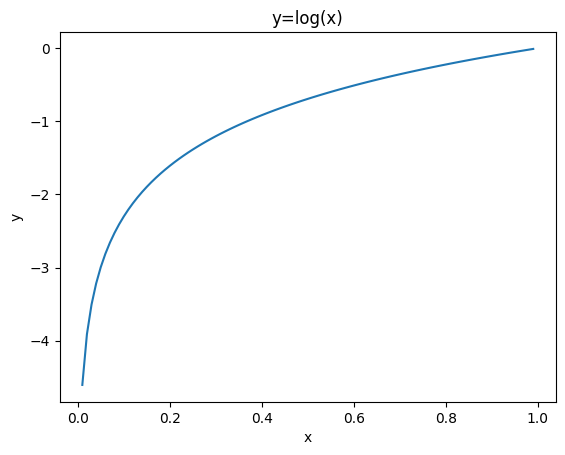

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(0.01,1,0.01)
y = np.log(x)
plt.title("y=log(x)") 
plt.xlabel("x") 
plt.ylabel("y") 
plt.plot(x,y)
plt.show()
plt.figure()

如自然对数的图形所示，当$x$等于1时，$y$为0；随着$x$向0靠近，$y$逐渐变小。因此，正确解标签对应的输出越大，交叉熵的值越接近0；当输出为1时，交叉熵误差为0。反之，如果正确解标签对应的输出越小，则交叉熵的值越大。

## 交叉熵的代码实现

在手写数字识别任务中，仅改动三行代码，就可以将在现有模型的损失函数替换成交叉熵（Cross_entropy）。

* 在读取数据部分，将标签的类型设置成int，体现它是一个标签而不是实数值（飞桨框架默认将标签处理成int64）。
* 在网络定义部分，将输出层改成“输出十个标签的概率”的模式。
* 在训练过程部分，将损失函数从均方误差换成交叉熵。

在数据处理部分，需要修改标签变量Label的格式，代码如下所示。
- 从：label = np.reshape(labels[i], [1]).astype('float32')
- 到：label = np.reshape(labels[i], [1]).astype('int64')

In [6]:
#数据处理部分之前的代码，保持不变
import os
import random
import paddle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import gzip
import json

# 创建一个类MnistDataset，继承paddle.io.Dataset 这个类
# MnistDataset的作用和上面load_data()函数的作用相同，均是构建一个迭代器
class MnistDataset(paddle.io.Dataset):
    def __init__(self, mode):
        datafile = './work/mnist.json.gz'
        data = json.load(gzip.open(datafile))
        # 读取到的数据区分训练集，验证集，测试集
        train_set, val_set, eval_set = data
        
        # 数据集相关参数，图片高度IMG_ROWS, 图片宽度IMG_COLS
        self.IMG_ROWS = 28
        self.IMG_COLS = 28

        if mode=='train':
            # 获得训练数据集
            imgs, labels = train_set[0], train_set[1]
        elif mode=='valid':
            # 获得验证数据集
            imgs, labels = val_set[0], val_set[1]
        elif mode=='eval':
            # 获得测试数据集
            imgs, labels = eval_set[0], eval_set[1]
        else:
            raise Exception("mode can only be one of ['train', 'valid', 'eval']")
        
        # 校验数据
        imgs_length = len(imgs)
        assert len(imgs) == len(labels), \
            "length of train_imgs({}) should be the same as train_labels({})".format(len(imgs), len(labels))
        
        self.imgs = imgs
        self.labels = labels

    def __getitem__(self, idx):
        # img = np.array(self.imgs[idx]).astype('float32')
        # label = np.array(self.labels[idx]).astype('int64')
        img = np.reshape(self.imgs[idx], [1, self.IMG_ROWS, self.IMG_COLS]).astype('float32')
        label = np.reshape(self.labels[idx], [1]).astype('int64')

        return img, label

    def __len__(self):
        return len(self.imgs)
# 声明数据加载函数，使用训练模式，MnistDataset构建的迭代器每次迭代只返回batch=1的数据
train_dataset = MnistDataset(mode='train')
# 使用paddle.io.DataLoader 定义DataLoader对象用于加载Python生成器产生的数据，
# DataLoader 返回的是一个批次数据迭代器，并且是异步的；
train_loader = paddle.io.DataLoader(train_dataset, batch_size=100, shuffle=True, drop_last=True)
val_dataset = MnistDataset(mode='valid')
val_loader = paddle.io.DataLoader(val_dataset, batch_size=128,drop_last=True)

在网络定义部分，需要修改输出层结构，代码如下所示。

- 从：self.fc = Linear(in_features=980, out_features=1)
- 到：self.fc = Linear(in_features=980, out_features=10)

In [7]:
# 定义 SimpleNet 网络结构
import paddle
from paddle.nn import Conv2D, MaxPool2D, Linear
import paddle.nn.functional as F
# 多层卷积神经网络实现
class MNIST(paddle.nn.Layer):
     def __init__(self):
         super(MNIST, self).__init__()
         
         # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
         self.conv1 = Conv2D(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=2)
         # 定义池化层，池化核的大小kernel_size为2，池化步长为2
         self.max_pool1 = MaxPool2D(kernel_size=2, stride=2)
         # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
         self.conv2 = Conv2D(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=2)
         # 定义池化层，池化核的大小kernel_size为2，池化步长为2
         self.max_pool2 = MaxPool2D(kernel_size=2, stride=2)
         # 定义一层全连接层，输出维度是10
         self.fc = Linear(in_features=980, out_features=10)
         
    # 定义网络前向计算过程，卷积后紧接着使用池化层，最后使用全连接层计算最终输出
    # 卷积层激活函数使用Relu，全连接层激活函数使用softmax
     def forward(self, inputs):
         x = self.conv1(inputs)
         x = F.relu(x)
         x = self.max_pool1(x)
         x = self.conv2(x)
         x = F.relu(x)
         x = self.max_pool2(x)
         x = paddle.reshape(x, [x.shape[0], 980])
         x = self.fc(x)
         return x

修改计算损失的函数，从均方误差（常用于回归问题）到交叉熵误差（常用于分类问题），代码如下所示。

- 从：loss = paddle.nn.functional.square_error_cost(predict, label)
- 到：loss = paddle.nn.functional.cross_entropy(predict, label)

In [8]:
def evaluation(model, datasets):
    model.eval()

    acc_set = list()
    for batch_id, data in enumerate(datasets()):
        images, labels = data
        images = paddle.to_tensor(images)
        labels = paddle.to_tensor(labels)
        pred = model(images)   # 获取预测值
        acc = paddle.metric.accuracy(input=pred, label=labels)
        acc_set.extend(acc.numpy())
    
    # #计算多个batch的准确率
    acc_val_mean = np.array(acc_set).mean()
    return acc_val_mean

In [9]:
#仅修改计算损失的函数，从均方误差（常用于回归问题）到交叉熵误差（常用于分类问题）
def train(model):
    model.train()
    #调用加载数据的函数
    # train_loader = load_data('train')
    # val_loader = load_data('valid')
    opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())
    EPOCH_NUM = 10
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            #前向计算的过程
            predicts = model(images)
            
            #计算损失，使用交叉熵损失函数，取一个批次样本损失的平均值
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            #每训练了200批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.step()
            # 清除梯度
            opt.clear_grad()
        # acc_train_mean = evaluation(model, train_loader)
        # acc_val_mean = evaluation(model, val_loader)
        # print('train_acc: {}, val acc: {}'.format(acc_train_mean, acc_val_mean))   
    #保存模型参数
    paddle.save(model.state_dict(), 'mnist.pdparams')
    
#创建模型    
model = MNIST()
#启动训练过程
train(model)

W0111 12:07:59.011126 297169 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.3, Runtime API Version: 12.0
W0111 12:07:59.012270 297169 gpu_resources.cc:164] device: 0, cuDNN Version: 8.9.


epoch: 0, batch: 0, loss is: 3.2821602821350098
epoch: 0, batch: 200, loss is: 0.3535505533218384
epoch: 0, batch: 400, loss is: 0.15332095324993134
epoch: 1, batch: 0, loss is: 0.32249099016189575
epoch: 1, batch: 200, loss is: 0.1377907693386078
epoch: 1, batch: 400, loss is: 0.1481732726097107
epoch: 2, batch: 0, loss is: 0.11854781955480576
epoch: 2, batch: 200, loss is: 0.05826783552765846
epoch: 2, batch: 400, loss is: 0.08223459869623184
epoch: 3, batch: 0, loss is: 0.036620158702135086
epoch: 3, batch: 200, loss is: 0.06138834357261658
epoch: 3, batch: 400, loss is: 0.14472360908985138
epoch: 4, batch: 0, loss is: 0.1024947464466095
epoch: 4, batch: 200, loss is: 0.03612769395112991
epoch: 4, batch: 400, loss is: 0.09460801631212234
epoch: 5, batch: 0, loss is: 0.04063503071665764
epoch: 5, batch: 200, loss is: 0.12071696668863297
epoch: 5, batch: 400, loss is: 0.032454557716846466
epoch: 6, batch: 0, loss is: 0.18590779602527618
epoch: 6, batch: 200, loss is: 0.077889777719974

虽然上述训练过程的损失明显比使用均方误差算法要小，但因为损失函数量纲的变化，我们无法从比较两个不同的Loss得出谁更加优秀。怎么解决这个问题呢？我们可以回归到问题的本质，谁的分类准确率更高来判断。在后面介绍完计算准确率和作图的内容后，读者可以自行测试采用不同损失函数下，模型准确率的高低。

至此，大家阅读论文中常见的一些分类任务模型图就清晰明了，如全连接神经网络、卷积神经网络，在模型的最后阶段，都是使用Softmax进行处理。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/309156e1b2f545ef88102fce6b4685fa3a12cf6334db47fa8fe0a281ecd89947" width="1000" hegiht="" ></center>
<center><br>图8：常见的分类任务模型图</br></center>
<br></br>

由于我们修改了模型的输出格式，因此使用模型做预测时的代码也需要做相应的调整。从模型输出10个标签的概率中选择最大的，将其标签编号输出。

In [13]:
# 读取一张本地的样例图片，转变成模型输入的格式
def load_image(img_path):
    # 从img_path中读取图像，并转为灰度图
    im = Image.open(img_path).convert('L')
    im = im.resize((28, 28), Image.LANCZOS)
    im = np.array(im).reshape(1, 1, 28, 28).astype(np.float32)
    # 图像归一化
    im = 1.0 - im / 255.
    return im

# 定义预测过程
model = MNIST()
params_file_path = 'mnist.pdparams'
img_path = 'work/example_0.jpg'
# 加载模型参数
param_dict = paddle.load(params_file_path)
model.load_dict(param_dict)
# 灌入数据
model.eval()
tensor_img = load_image(img_path)
#模型反馈10个分类标签的对应概率
results = model(paddle.to_tensor(tensor_img))
#取概率最大的标签作为预测输出
lab = np.argsort(results.numpy())
print("本次预测的数字是: ", lab[0][-1])

本次预测的数字是:  0
